In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd

%matplotlib inline

In [12]:
sns.set_theme()

In [13]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')

In [14]:
env_name = 'pendulum'

In [15]:
pend_paths = {# 'BAC (seed 12)': 'random_init_12_2021-08-05/10-02-01/',
         'BAC': 'pend_norm_tele_mg_3mc_2021-08-16/21-16-21',
         'Rollout BAC': 'rollout_bac_telenorm_multi_2021-08-17/22-44-48/',
         'MBRL': 'default_2021-08-16/16-03-38',
         'SAC': 'sac_pendulum_2021-08-31/10-25-17/',
         'TD3': 'td3_pendulum_2021-08-31/16-43-52/',
         'PPO': 'ppo_pendulum_2021-08-31/12-20-16/',
         
        }

In [16]:
cartpole_paths = {
         'BAC': 'cartpole_multistart_2021-08-20/12-52-46/',
         'Rollout BAC': 'cartpole_multistart_rollout_bac_2021-08-19/17-59-03/',
         'MBRL': 'cartpole_multistart_mbrl_2021-08-18/23-45-13/',
         'SAC': 'sac_cartpole_working/10-16-34/',
         'TD3': 'td3_cartpole_2021-08-31/16-45-53/',
         'PPO': 'cartpole_ppo_fixed_2021-08-31/extra/',
}

In [17]:
lava_paths = {
        'BAC': 'bac_lava_path_2021-09-09/10-57-31/',
}

In [18]:
reacher_paths = {
        'BAC (uniform)': 'bac_reacher_2021-09-01/17-14-04/',
        'BAC (path sampling)': 'bac_reacher_rand_2021-09-01/17-14-02/',
        'SAC': 'sac_reacher_2021-09-02/22-41-22/',
}

In [19]:
all_paths = {"cartpole": cartpole_paths, "pendulum": pend_paths, "reacher": reacher_paths, 'lava_path': lava_paths}
paths = all_paths[env_name]
gt = {"pendulum": -200, "cartpole": -12.5, "reacher": -5, 'lava_path': -23}
gt_val = gt[env_name]

In [20]:
def process_bac(data):
    returns = np.vstack(data['Eval Returns'])

    data['Eval Mean Returns'] = returns.mean(axis=1)
    data['Eval Std Returns'] = returns.std(axis=1) / np.sqrt(returns.shape[1])
    return data

def process_baseline(data):
    out = {}
    out['Eval Mean Returns'] = data["evaluation/Returns Mean"]
    out['Eval ndata'] = data['exploration/num steps total']
    out['Eval Std Returns'] = data['evaluation/Returns Std']
    return out

In [21]:
data = {}
for key, path in paths.items():
    print(key)
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_exp_path = baseline_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    print(f"Data for {key} not found!")

BAC
Rollout BAC
MBRL
SAC
TD3
PPO


Text(0.5, 0.98, 'Control Performance on pendulum')

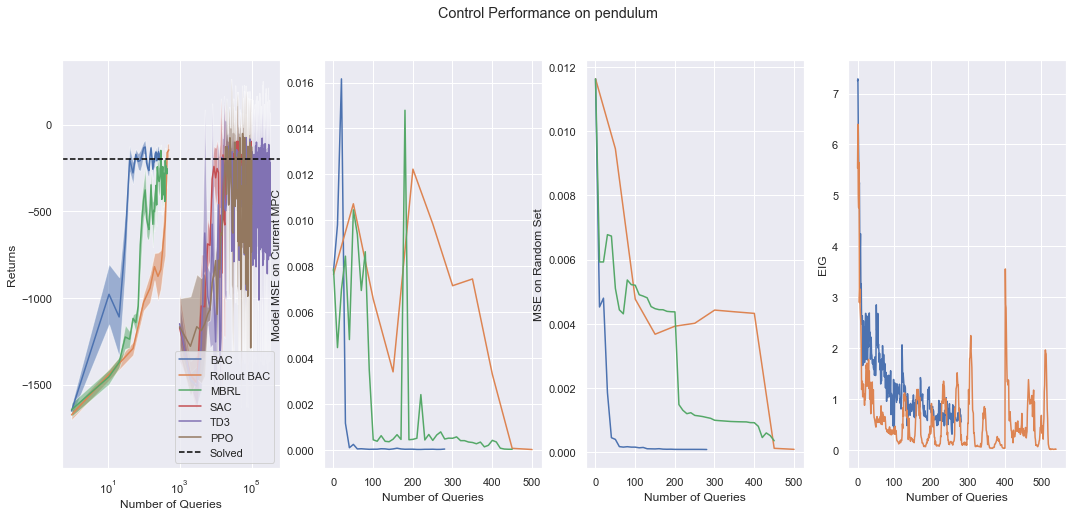

In [22]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata, mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata, mses, label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax4.plot(acqs, label=key)
    else:
        ax4.plot([], label=key)

        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(gt_val, color='black', linestyle='--', label='Solved')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax4.set_xlabel('Number of Queries')
ax4.set_ylabel('EIG')
if env_name == 'lava_path':
    ax1.set_ylim(-1000, 0)
ax1.set_xscale('log')
fig.suptitle(f"Control Performance on {env_name}")


Text(0.5, 0.98, 'Control Performance on pendulum')

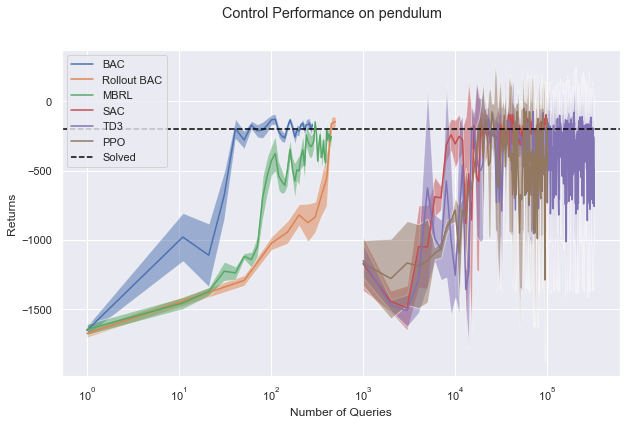

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
ax.set_xlabel('Number of Queries')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label='Solved')
ax.legend()
ax.set_xscale('log')
fig.suptitle(f"Control Performance on {env_name}")